In [165]:
import matplotlib.pylab as plt 
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

Text(0, 0.5, 'TPR')

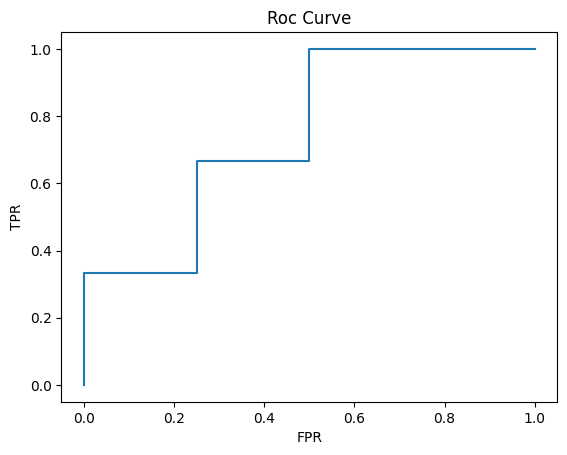

In [166]:
pred_y = [0.95, 0.85, 0.8, 0.7, 0.55, 0.45, 0.4, 0.3, 0.2, 0.1]
y = [1, 1, 0, 1, 1, 0, 1, 1, 0, 0]
fpr, tpr, thresholds = roc_curve(y, pred_y)
plt.plot(fpr, tpr)
plt.title("Roc Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [167]:
print(tpr)
print(fpr)
print(thresholds)

[0.         0.16666667 0.33333333 0.33333333 0.66666667 0.66666667
 1.         1.        ]
[0.   0.   0.   0.25 0.25 0.5  0.5  1.  ]
[ inf 0.95 0.85 0.8  0.55 0.45 0.3  0.1 ]


### Question 2

### Note:
**This was written when I was in undergrad, so that is why the comments are the way they are. This is my own original work.**

In [168]:
import numpy as np
from scipy import stats
from sklearn.metrics import pairwise_distances

class KNN:
    def __init__(self, k, aggregation_function):
        self.k = k
        self.aggregate_function = aggregation_function

    def fit(self, X, y):
        self.X = X
        self.y = np.reshape(y, (y.shape[0],1))
        # self.y = y        
        
    def predict(self, X):
        distances = pairwise_distances(X=self.X, Y=X, metric="euclidean")
        # this one is somehow faster than cdist from scipy...
        sorted_distances = np.argsort(distances, axis=0)
        knn = sorted_distances[:self.k,:]

        # knn_values = distances[knn.flatten(),repeated_columns]
        test_x = np.hstack((self.X, self.y))
        knn_values = test_x[knn]
        shape = knn_values.shape
        dims = len(shape)
        predictions = knn_values[:,:,(shape[dims-1]-1)]

        if self.aggregate_function == 'average':
            mean = np.mean(predictions, axis=0)
            return mean
        else:
            mode = stats.mode(predictions)[0]
            return mode

In [169]:
class LinearModel:
    def __init__(self):
        self.weights = None
        self.bias = 0

    def fit(self, X, y, epochs = 1, alpha = 0.01):
        X = X.to_numpy()
        X = np.float64(X)
        y = y.to_numpy()
        self.weights = np.zeros(X.shape[1])
        for epoch in range(epochs):
            pred = self.weights @ X.T + self.bias
            sigmoid = self._sigmoid(pred)
            grad_weights, grad_bias = self._cross_entropy_deriv(sigmoid, y, X)
            self.weights = self.weights - (alpha * grad_weights)
            self.bias = self.bias - (alpha * grad_bias)

    def _sigmoid(self, preds):
        return np.array([self._sigmoid_eqn(pred) for pred in preds])

    def _sigmoid_eqn(self, x):
        # https://www.blog.dailydoseofds.com/p/a-highly-overlooked-point-in-the#:~:text=The%20standard%20sigmoid%20function%20can,use%20both%20variations%20of%20sigmoid.
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)
    
    def _cross_entropy_deriv(self, y_pred, y_true, X):
        diff = y_pred - y_true
        return X.T @ diff , np.mean(diff) # second one for the weights
    
    def predict(self, X):
        return self._sigmoid(self.weights @ X.T + self.bias)  # this gets prob, gotta apply .round() if if you want classifications on a 0.5 boundary

In [170]:
training_data = np.loadtxt('./D2z.txt')
x_train = training_data[:, [0,1]]
y_train = training_data[:, [-1]]

x_test = np.arange(-2, 2.1, 0.1)
y_test = np.arange(-2, 2.1, 0.1)
xv, yv = np.meshgrid(x_test, y_test)

print(yv.shape)

x_flat = np.reshape(xv, (-1, 1))
y_flat = np.reshape(yv, (-1, 1))

knn = KNN(k=1, aggregation_function="mode")
knn.fit(x_train, y_train)

grid_points = np.concatenate((x_flat, y_flat), axis=1)
knn_pred = knn.predict(grid_points)

sns.scatterplot(x=x_flat[:, 0], y=y_flat[:, 0], hue=knn_pred)
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], color="black")
plt.title("1nn Graph")
plt.xlabel("X1")
plt.ylabel("y1")

In [177]:
email_data = pd.read_csv('./emails.csv')
email_data.set_index('Email No.', inplace=True)
email_data.shape

(5000, 3001)

In [178]:
fold_1 = email_data.iloc[0:1000, :]
fold_2 = email_data.iloc[1000:2000, :]
fold_3 = email_data.iloc[2000:3000, :]
fold_4 = email_data.iloc[3000:4000, :]
fold_5 = email_data.iloc[4000:, :]
folds = [fold_1, fold_2, fold_3, fold_4, fold_5]


In [179]:
for fold in folds:
    print(fold.shape)

(1000, 3001)
(1000, 3001)
(1000, 3001)
(1000, 3001)
(1000, 3001)


In [180]:
models = []
for index, fold in enumerate(folds):
    test_set_x = fold.loc[:, fold.columns != "Prediction"]
    test_set_y = fold['Prediction']

    train_folds = []
    for index_2, fold_2 in enumerate(folds):
        if index == index_2:
            continue
        else:
            train_folds.append(fold_2)

    train_set = pd.concat(train_folds)
    # print(train_set.shape)
    train_set_x = train_set.loc[:, train_set.columns != "Prediction"]
    train_set_y = train_set['Prediction']

    knn_classifier = KNN(k=1, aggregation_function="mode")
    # knn_classifier = KNeighborsClassifier(n_neighbors=1) # testing with sklearn
    knn_classifier.fit(train_set_x, train_set_y)
    preds = knn_classifier.predict(test_set_x)

    precision, recall, fscore, support = precision_recall_fscore_support(y_true=test_set_y, y_pred=preds, labels=[1])
    accuracy = accuracy_score(y_pred=preds, y_true=test_set_y)

    print(f'Test set is set {index + 1}. \n Precision: {precision},\n Recall: {recall},\n Accuracy: {accuracy}\n')

Test set is set 1. 
 Precision: [0.65363128],
 Recall: [0.82105263],
 Accuracy: 0.825

Test set is set 2. 
 Precision: [0.68965517],
 Recall: [0.86642599],
 Accuracy: 0.855

Test set is set 3. 
 Precision: [0.72205438],
 Recall: [0.8415493],
 Accuracy: 0.863

Test set is set 4. 
 Precision: [0.72155689],
 Recall: [0.81972789],
 Accuracy: 0.854

Test set is set 5. 
 Precision: [0.60519481],
 Recall: [0.76143791],
 Accuracy: 0.775



In [181]:
average_accs = []
k_range = [1, 3, 5, 7, 10]

for k in k_range:
    print("Using k:", k)
    accuracies = []
    for index, fold in enumerate(folds):
        test_set_x = fold.loc[:, fold.columns != "Prediction"]
        test_set_y = fold['Prediction']

        train_folds = []
        for index_2, fold_2 in enumerate(folds):
            if index == index_2:
                continue
            else:
                train_folds.append(fold_2)

        train_set = pd.concat(train_folds)
        # print(train_set.shape)
        train_set_x = train_set.loc[:, train_set.columns != "Prediction"]
        train_set_y = train_set['Prediction']

        knn_classifier = KNN(k, "mode")
        # knn_classifier = KNeighborsClassifier(n_neighbors=k, metric="euclidean", algorithm="brute") #testing with sklearn
        knn_classifier.fit(train_set_x, train_set_y)
        preds = knn_classifier.predict(test_set_x)

        precision, recall, fscore, support = precision_recall_fscore_support(y_true=test_set_y, y_pred=preds, labels=[1])
        accuracy = accuracy_score(y_pred=preds, y_true=test_set_y)
        accuracies.append(accuracy)

    average_accs.append((sum(accuracies)/len(accuracies)))

Using k: 1
Using k: 3
Using k: 5
Using k: 7
Using k: 10


Text(0, 0.5, 'Average Fold Accuracy')

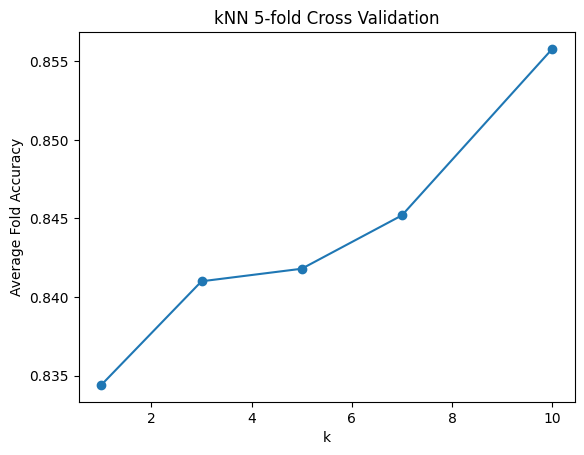

In [182]:
plt.plot(k_range, average_accs, marker="o")
plt.title("kNN 5-fold Cross Validation")
plt.xlabel("k")
plt.ylabel("Average Fold Accuracy")

In [184]:
models = []
for index, fold in enumerate(folds):
    test_set_x = fold.loc[:, fold.columns != "Prediction"]
    test_set_y = fold['Prediction']

    train_folds = []
    for index_2, fold_2 in enumerate(folds):
        if index == index_2:
            continue
        else:
            train_folds.append(fold_2)

    train_set = pd.concat(train_folds)
    # print(train_set.shape)
    train_set_x = train_set.loc[:, train_set.columns != "Prediction"]
    train_set_y = train_set['Prediction']

    linear_model = LinearModel()
    linear_model.fit(train_set_x, train_set_y, epochs=100, alpha=0.005)
    preds = linear_model.predict(test_set_x)
    precision, recall, fscore, support = precision_recall_fscore_support(y_true=test_set_y, y_pred=preds.round(), labels=[1], zero_division=np.nan)
    accuracy = accuracy_score(y_pred=preds.round(), y_true=test_set_y)

    print(f'Test set is set {index + 1}. \n Precision: {precision},\n Recall: {recall},\n Accuracy: {accuracy}\n')

Test set is set 1. 
 Precision: [0.82608696],
 Recall: [0.2],
 Accuracy: 0.76

Test set is set 2. 
 Precision: [0.77777778],
 Recall: [0.15162455],
 Accuracy: 0.753

Test set is set 3. 
 Precision: [0.94736842],
 Recall: [0.06338028],
 Accuracy: 0.733

Test set is set 4. 
 Precision: [0.57356077],
 Recall: [0.91496599],
 Accuracy: 0.775

Test set is set 5. 
 Precision: [0.39499305],
 Recall: [0.92810458],
 Accuracy: 0.543



In [185]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(email_data.loc[:, email_data.columns != "Prediction"], email_data['Prediction'], test_size=0.3, stratify=email_data['Prediction'])
knn_classifier = KNN(5, "average")
knn_classifier.fit(X_train, y_train)
knn_preds = knn_classifier.predict(X_test)


linear_model = LinearModel()
linear_model.fit(X_train, y_train, epochs=1000, alpha=0.0001)
linear_preds = linear_model.predict(X_test)
print(accuracy_score(y_pred=linear_preds.round(), y_true=y_test))

0.896


Text(0, 0.5, 'TPR')

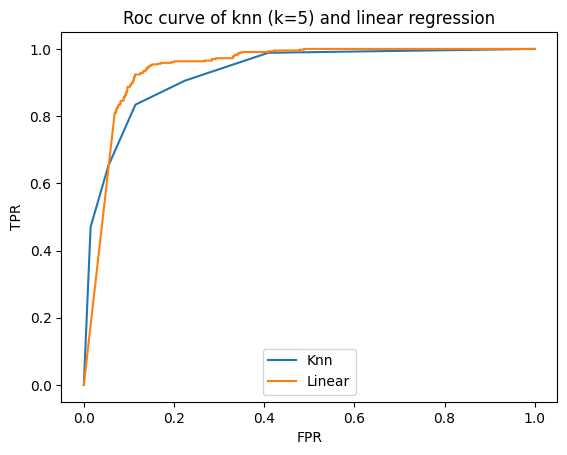

In [187]:

knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_preds, pos_label=1, drop_intermediate=False)
lin_fpr, lin_tpr, lin_thresholds = roc_curve(y_test, linear_preds, pos_label=1, drop_intermediate=False)

# print(lin_thresholds)
plt.plot(knn_fpr, knn_tpr, label="Knn")
plt.plot(lin_fpr, lin_tpr, label="Linear")
plt.legend(loc = "lower center")
plt.title("Roc curve of knn (k=5) and linear regression")
plt.xlabel("FPR")
plt.ylabel("TPR")